# Konwolucyjna sieć neuronowa (ang. Convolutional neural network) o prostej architekturze w analizie czerniaka

## Tworzymy model

In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-i0zef8sk because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Ładujemy dane do trenowania i walidacji.

In [2]:
datagen = ImageDataGenerator(rescale=1. / 255, 
                             validation_split=0.2,
                             rotation_range=180,
                             horizontal_flip=True,
                             vertical_flip=True,
                             brightness_range=(0.2,1.5))
training_set = datagen.flow_from_directory('/isic-train-large',
                                           target_size=(128, 128),
                                           batch_size=32,
                                           class_mode='categorical',
                                           subset='training')
validation_set = datagen.flow_from_directory('/isic-train-large',
                                           target_size=(128, 128),
                                           batch_size=32,
                                           class_mode='categorical',
                                           subset='validation')

Found 23400 images belonging to 10 classes.
Found 5845 images belonging to 10 classes.


Zapisujemy ilość diagnoz do zmiennej.

In [3]:
DIAGNOSIS_NUMBER = len(training_set.class_indices)

Budujemy model - sieć konwolucyjną z 3 warstwami konwolucyjnymi (ang. convolutional layer) i 2 warstwami gęstymi (ang. dense layer).

In [4]:
model = Sequential([
    # pierwsza warstwa konwolucyjna
    Conv2D(filters=64, 
           kernel_size=3, 
           activation='relu', 
           input_shape=(128, 128, 3)),
    MaxPool2D(pool_size=2, strides=2),

    # druga warstwa konwolucyjna
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),

    # trzecia warstwa konwolucyjna
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    
    
    BatchNormalization(),
    
    # trasformacja macierzy do tablicy (2D -> 1D)
    Flatten(),
    
    # 2 warstwy gęste
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    
    Dense(units=128, activation='relu'),
    Dropout(0.2),

    # warstwa wyjściowa
    Dense(units=DIAGNOSIS_NUMBER, activation='softmax')
])

In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Dodajemy funkcjonalność zbierania danych o wydajności modelu do Tensorboard.

In [6]:
log_dir = '../logs/fit/' + datetime.datetime.now().strftime('cnn')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

Dodajemy funkcjonalność zapisywania modelu w trakcie jego trenowania. Zwóćmy uwagę, że zapisywany jest tylko jeden model i lepszy nadpisuje gorszy.

In [7]:
checkpoint_path = 'checkpoints/cnn.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto')

Dodajemy funkcjonalność zatrzymania trenowania modelu, jeśli nie będzie poprawy w ciągu 10 epoch.

In [8]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=10, restore_best_weights=True)

Trenujemy model.

In [9]:
model.fit(training_set, validation_data=validation_set, epochs=200, callbacks=[tensorboard_callback,
                                                                               checkpoint_callback,
                                                                               early_stop_callback])

Epoch 1/200
732/732 [==============================] - 1805s 2s/step - loss: 1.2915 - accuracy: 0.6203 - val_loss: 1.0008 - val_accuracy: 0.6496

Epoch 00001: val_loss improved from inf to 1.00084, saving model to checkpoints/cnn.ckpt
INFO:tensorflow:Assets written to: checkpoints/cnn.ckpt/assets
Epoch 2/200
732/732 [==============================] - 1785s 2s/step - loss: 1.0475 - accuracy: 0.6646 - val_loss: 1.1782 - val_accuracy: 0.6428

Epoch 00002: val_loss did not improve from 1.00084
Epoch 3/200
732/732 [==============================] - 1784s 2s/step - loss: 1.0209 - accuracy: 0.6715 - val_loss: 0.9945 - val_accuracy: 0.6698

Epoch 00003: val_loss improved from 1.00084 to 0.99453, saving model to checkpoints/cnn.ckpt
INFO:tensorflow:Assets written to: checkpoints/cnn.ckpt/assets
Epoch 4/200
732/732 [==============================] - 1786s 2s/step - loss: 0.9838 - accuracy: 0.6853 - val_loss: 1.0454 - val_accuracy: 0.6578

Epoch 00004: val_loss did not improve from 0.99453
Epoch 

## Szacujemy dokładność modelu

Ładujemy dane do testowania.

In [10]:
datagen = ImageDataGenerator(rescale=1. / 255)
testing_set = datagen.flow_from_directory('/isic-test-large',
                                           target_size=(128, 128),
                                           batch_size=32,
                                           class_mode='categorical')

Found 7312 images belonging to 10 classes.


Pobieramy diagnozy z danych testowych.

In [11]:
true_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

Prognozujemy diagnozy dla każdego obrazu.

In [12]:
predicted_labels = model.predict(testing_set)

Obliczamy punkty wykresu ROC (Receiver operating characteristic) i metrykę AUC (Area under the curve).

In [13]:
fpr = dict()
tpr = dict()
auc_metric = dict()

diagnosis_index_dict = {v: k for k, v in training_set.class_indices.items()}

for i in range(DIAGNOSIS_NUMBER):
    diagnosis = diagnosis_index_dict[i]
    fpr[diagnosis], tpr[diagnosis], _ = roc_curve(true_labels[:, i], predicted_labels[:, i])
    auc_metric[diagnosis] = auc(fpr[diagnosis], tpr[diagnosis])

Rysujemy wykres ROC (Receiver operating characteristic).

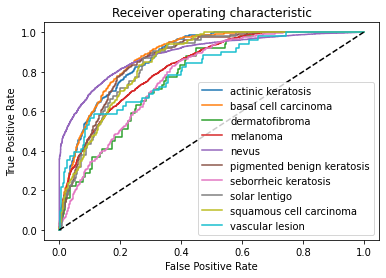

In [14]:
for diagnosis in training_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Metryki AUC do każdej diagnozy.

In [15]:
auc_metric

{'actinic keratosis': 0.8730350431396797,
 'basal cell carcinoma': 0.8808727816267438,
 'dermatofibroma': 0.7775698466086146,
 'melanoma': 0.8252598595910818,
 'nevus': 0.8909023376537106,
 'pigmented benign keratosis': 0.8608021842793417,
 'seborrheic keratosis': 0.7796469911865713,
 'solar lentigo': 0.8492567456924001,
 'squamous cell carcinoma': 0.8514315236028919,
 'vascular lesion': 0.8057659642840748}